In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, We will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("../Resources/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Creating a Return column using "Settle" price percentage returns, drop any nan"s, 
# replace inf, -inf values with np.nan"s and check the results:
yen_futures['Return'] = yen_futures['Settle'].pct_change() * 100
yen_futures['Return'] = yen_futures['Return'].replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [5]:
# lets create a lagged return column using the shift function
yen_futures['Lagged_Return'] = yen_futures['Return'].shift()
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829,0.409123
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604


### Train Test Split

In [6]:
# Creating a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [7]:
# we will now create four dataframes for X and Y  (X_train, Y_train, X_test & Y_test)
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
X_train = train['Lagged_Return'].to_frame()
X_test = test['Lagged_Return'].to_frame()
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
Y_train = train['Return']
Y_test = test['Return']

In [8]:
X_train

,Lagged_Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


# Linear Regression Model

In [9]:
# Creating a Linear Regression model and fit it to the training data (X_train, Y_train):
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# We will  prediction of "y" values or Predicted_Return using the test dataset and display 1st 10 predictions
predicted_return = model.predict(X_test)
predicted_return[:10]

array([-0.00959876, -0.01003326, -0.00680657, -0.00697128, -0.00612582,
       -0.00862161, -0.01058223, -0.0152206 , -0.00964767, -0.00834913])

In [11]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results= Y_test.to_frame()
Results['Predicted_Return'] = predicted_return

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

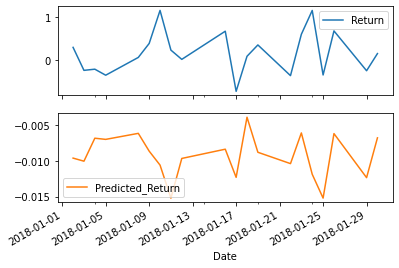

In [12]:
# Plot the first 20 predicted Returns vs the actual Returns
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [13]:
# using sklearn module, we'll calculate the mean_squared_error (MSE) -
# on actual versus predicted test "y" and find root meaan squred error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Results['Return'], Results['Predicted_Return'])
rmse = np.sqrt(mse)
print ("Out-of-Sample Root Mean Squred Error is: " f'{rmse}')

Out-of-Sample Root Mean Squred Error is: 0.41545437184712763


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [14]:
# Construct a dataframe using just the "y" training data and add an in sample predictoin column
InSample_Results = Y_train.to_frame()   
InSample_Results['In_Sample Return'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample) and evaluate RMSE
in_mse=mean_squared_error(InSample_Results['Return'], InSample_Results['In_Sample Return'])
in_rmse=np.sqrt(in_mse)
in_rmse

print ("In-Sample Root Mean Squred Error is: " f'{in_rmse}')

In-Sample Root Mean Squred Error is: 0.5962037920929946


# Conclusions

1. Using Linear Regression model and Train, Test Data sets, our In sample predictions have slightly higher Root Mean Squared Error (RMSE) compared to Out of Sample RMSE.
2. While the model performed slightly better on the out of sample data set, it is has resulted in slightly higher RMSE against the data the model has been trained. 
3. This could be due to certain market conditions/risk factors which influenced the Train data period(pre-2018)  were not prominant during test data perioed (post 2017).
4.  As we continue to train the model over the period of time, the RMSE difference between the models might become negligible and the model will then be most likely be used in real time. 